# Molecular Toxicity Prediction
This project focuses on predicting the toxicity of molecules by utilizing graph classification techniques in PyTorch. By representing molecules as graphs, where nodes correspond to atoms and edges to chemical bonds, we can analyze their atomic composition and arrangement to determine their biological behaviors and properties. Using high-throughput experimental data provided in three files (train_data.pt, valid_data.pt, and test_data.pt), we aim to classify molecular properties and interactions, including activation or inhibition, binding affinity, and dose-response relationships. This notebook establishes a baseline for molecular toxicity prediction, leveraging PyTorch 2.1.0 for implementation.

# Install package

In [1]:
# New these two packages
!pip install torch_geometric
!pip install rdkit-pypi

# Some tutorials.



1.   Pytorch geometric package: https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html
2.   PyTorch Geometric for Graph-Based Molecular Property Prediction using MoleculeNet benchmark: https://medium.com/@nikopavl4/pytorch-geometric-for-graph-based-molecular-property-prediction-using-moleculenet-benchmark-41e36369d3c6
3. Graph neural networks for graph classification. https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing
4. Related github repository on molecular property predictions. https://github.com/yifeiwang15/MotifConv/tree/main/MCM_for_molecule_benchmarks


## What are node and edge features in a molecule.

### Node features:

**Atomic number**: Number of protons in the nucleus of an atom. It’s characteristic of a chemical element and determines its place in the periodic table.

**Chirality**: A molecule is chiral if it is distinguishable from its mirror image by any combination of rotations, translations, and some conformational changes. Different types of chirality exist depending on the molecule and the arrangement of the atoms.

**Degree**: Number of directly-bonded neighbors of the atom.
Formal charge: Charge assigned to an atom. It reflects the electron count associated with the atom compared to the isolated neutral atom.

**Number of H**: Total number of hydrogen atoms on the atom.
Number of radical e: Number of unpaired electrons of the atom.

**Hybridization**: Atom’s hybridization.

**Is aromatic**: Whether it is included in a cyclic structure with pi bonds. This type of structure tends to be very stable in comparison with other geometric arrangements of the same atoms.

**Is in ring**: Whether it is included in a ring (a simple cycle of atoms and bonds in a molecule).

### Edge features:

**Bond type:**: Whether the bond is single, double, triple, or aromatic.

**Stereo Type:** Stereo configuration of the bond.

**Is conjugated**: Whether or not the bond is considered to be conjugated.



# Dataset preparation and train-valid splitting.

In [1]:
import torch
import torch_geometric
import numpy as np
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
import pickle
import pandas as pd

/Users/defnecoban/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load datasets. The training and validation sets contain both molecules and their property labels. The test set only contain molecules.
# There are 12 property tasks for prediction. Some properties labels are missing (i.e., nan). You can ignore them.
train_dataset = torch.load("train_data.pt")
valid_dataset = torch.load("valid_data.pt")
test_dataset = torch.load("test_data.pt")

print(f'Size of training set: {len(train_dataset)}')
print(f'Size of validation set: {len(valid_dataset)}')
print(f'Size of test set: {len(test_dataset)}')

Size of training set: 6264
Size of validation set: 783
Size of test set: 784


In [3]:
# one graph example
g = train_dataset[0]
print(g)

print("Get node feature matrix:")
print(g.x)
print(g.x.shape) # (num_of_nodes, num_of_node_features)

print("Get edge index matrix:")
print(g.edge_index)
print(g.edge_index.shape) # (2, num_of_edges)

print("Get edge attribute matrix:")
print(g.edge_attr)
print(g.edge_attr.shape) # (num_of_edges, num_of_edge_features)

print("Get molecular property labels:")
print(g.y)
print(g.y.shape) # (1, 12)

Data(x=[11, 9], edge_index=[2, 20], edge_attr=[20, 3], y=[1, 12], smiles='CC(O)(P(=O)(O)O)P(=O)(O)O')
Get node feature matrix:
tensor([[ 6,  0,  4,  5,  3,  0,  4,  0,  0],
        [ 6,  0,  4,  5,  0,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [15,  0,  4,  5,  0,  0,  4,  0,  0],
        [ 8,  0,  1,  5,  0,  0,  3,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [15,  0,  4,  5,  0,  0,  4,  0,  0],
        [ 8,  0,  1,  5,  0,  0,  3,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0]])
torch.Size([11, 9])
Get edge index matrix:
tensor([[ 0,  1,  1,  1,  1,  2,  3,  3,  3,  3,  4,  5,  6,  7,  7,  7,  7,  8,
          9, 10],
        [ 1,  0,  2,  3,  7,  1,  1,  4,  5,  6,  3,  3,  3,  1,  8,  9, 10,  7,
          7,  7]])
torch.Size([2, 20])
Get edge attribute matrix:
tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
 

As we can observe, we have 11 nodes (rows) and each node has 9 features (columns). However, the features provided by Moleculenet are discrete and of type long, so we need to convert them first to continuous embeddings in order to feed them in any ML model.

For example, the first column indicates the atomic number of a node, where 1 represents Hydrogen, 6 represents Carbon, 8 for Oxygen, according to periodic table of elements.

In [4]:
# Example of preparing data loaders.
# You can use any batch size and see what happens in model performance.

from torch_geometric.data import DataLoader

batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/Users/defnecoban/opt/miniconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# Example of creating one mini-batch
# See more info about mini-batch in pytorch geometric in https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html
batch = next(iter(train_loader))
print(batch)

DataBatch(x=[563, 9], edge_index=[2, 1156], edge_attr=[1156, 3], y=[32, 12], smiles=[32], batch=[563], ptr=[33])


# Visualization of molecules

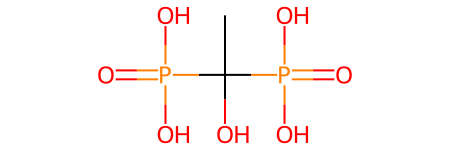

In [6]:
# visualize one 2D molecule.
from rdkit import Chem
Chem.MolFromSmiles(g.smiles)

#  Building Graph Convolutional Network

In [7]:
# Atom encoder

class AtomEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(AtomEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(9):
            self.embeddings.append(torch.nn.Embedding(100, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, x):
        x = x.long()
        
        if x.dim() == 1:
            x = x.unsqueeze(1)

        out = 0
        for i in range(x.size(1)):
            out += self.embeddings[i](x[:, i])
        return out


# A simple graph neural network model

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap
import torch.nn.functional as F
from torch.nn import Linear
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.emb = AtomEncoder(hidden_channels=hidden_channels)
        self.conv1 = GCNConv(hidden_channels,hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, batch):
        x , edge_index, batch_size = batch.x, batch.edge_index, batch.batch
        
        x = self.emb(x)

        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        
        x = x.relu()
        x = self.conv2(x, edge_index)
        
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = gap(x, batch_size)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [8]:
# create a model
model = GCN(32, 9, 12)

# prediction
out = model(batch)
print(out.shape) #(num_of_graph, num_of_task)


torch.Size([32, 12])


# Start training the GCN

In [9]:
# loss function and optimizer
import torch.nn as nn
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.BCEWithLogitsLoss(reduction = "none")

In [10]:
# train and eval function
from sklearn.metrics import roc_auc_score
def train(model, device, loader, optimizer):
    model.train()

    for step, batch in enumerate(loader):
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(pred.shape).to(torch.float64)

        optimizer.zero_grad()
        ## ignore nan targets (unlabeled) when computing training loss.
        is_labeled = batch.y == batch.y
        loss = criterion(pred.to(torch.float32)[is_labeled], batch.y.to(torch.float32)[is_labeled]).mean()
        loss.backward()
        optimizer.step()

def eval(model, device, loader):
    model.eval()
    y_true = []
    y_pred = []
    # For every batch in test loader
    for batch in loader:

        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true.append(batch.y.view(pred.shape))
            y_pred.append(pred)

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()
    # Compute the ROC - AUC score and store as history
    rocauc_list = []

    for i in range(y_true.shape[1]):
        #AUC is only defined when there is at least one positive data.
        if np.sum(y_true[:,i] == 1) > 0 and np.sum(y_true[:,i] == 0) > 0:
            # ignore nan values
            is_labeled = y_true[:,i] == y_true[:,i]
            rocauc_list.append(roc_auc_score(y_true[is_labeled,i], y_pred[is_labeled,i]))

    if len(rocauc_list) == 0:
        raise RuntimeError('No positively labeled data available. Cannot compute ROC-AUC.')

    return {'rocauc': sum(rocauc_list)/len(rocauc_list)}


In [11]:
# Training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Start training...")
for epoch in range(1, 20):
    print("====epoch " + str(epoch))

    # training
    train(model, device, train_loader, optimizer)

    # evaluating
    train_acc = eval(model, device, train_loader)
    val_acc = eval(model, device, val_loader)
    print({'Train': train_acc, 'Validation': val_acc})



Start training...
====epoch 1
{'Train': {'rocauc': 0.6934363319535813}, 'Validation': {'rocauc': 0.6638609055311179}}
====epoch 2
{'Train': {'rocauc': 0.710108537571113}, 'Validation': {'rocauc': 0.6722307325644348}}
====epoch 3
{'Train': {'rocauc': 0.7291279938561535}, 'Validation': {'rocauc': 0.702837336240314}}
====epoch 4
{'Train': {'rocauc': 0.7400275323165998}, 'Validation': {'rocauc': 0.7133099678195949}}
====epoch 5
{'Train': {'rocauc': 0.7485362178464104}, 'Validation': {'rocauc': 0.7198246707268581}}
====epoch 6
{'Train': {'rocauc': 0.7539066699475044}, 'Validation': {'rocauc': 0.7270453404123515}}
====epoch 7
{'Train': {'rocauc': 0.7612414990122806}, 'Validation': {'rocauc': 0.7272809293202961}}
====epoch 8
{'Train': {'rocauc': 0.7601087416648205}, 'Validation': {'rocauc': 0.732634011619033}}
====epoch 9
{'Train': {'rocauc': 0.7727335522869624}, 'Validation': {'rocauc': 0.7337990298386572}}
====epoch 10
{'Train': {'rocauc': 0.7729444654809609}, 'Validation': {'rocauc': 0.732

# Hyperparameter Tuning for GCN 

In [12]:
def calculate_roc_auc(model, device, loader):
    # Set model to evaluation mode
    model.eval()
    
    # Initialize lists for true labels and predictions
    y_true = []  # Ground truth
    y_pred = []  # Predictions
    
    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Iterate through data loader batches
        for batch in loader:
            # Move batch data to the specified device
            batch = batch.to(device)
            
            # Get model predictions and store true labels and predictions
            pred = model(batch)
            y_true.append(batch.y.view(pred.shape))
            y_pred.append(pred)

    # Concatenate lists into numpy arrays
    y_true = torch.cat(y_true, dim=0).numpy()
    y_pred = torch.cat(y_pred, dim=0).numpy()

    # Calculate ROC AUC scores for each class with labels
    rocauc_list = []
    for i in range(y_true.shape[1]):
        if np.sum(y_true[:, i] == 1) > 0 and np.sum(y_true[:, i] == 0) > 0:
            is_labeled = y_true[:, i] == y_true[:, i]
            rocauc_list.append(roc_auc_score(y_true[is_labeled, i], y_pred[is_labeled, i]))

    # Calculate and return the average ROC AUC score (if any)
    return sum(rocauc_list) / len(rocauc_list) if len(rocauc_list) > 0 else 0


In [13]:
# Hyperparameters to tune
hidden_channels_options = [16, 32, 64]  # Possible values for the number of hidden channels
learning_rate_options = [0.01, 0.001, 0.0001]  # Possible learning rates
dropout_rate_options = [0.1, 0.3, 0.5]  # Possible dropout rates

best_roc_auc = 0  # Initialize the best ROC AUC score
best_params = {}  # Initialize a dictionary to store the best hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else torch.device("cpu"))  # Set the device to GPU if available, otherwise use CPU

# Loop through different combinations of hyperparameters
for hidden_channels in hidden_channels_options:
    for learning_rate in learning_rate_options:
        for dropout_rate in dropout_rate_options:
            # Create a Graph Convolutional Network (GCN) model with specified hyperparameters
            model = GCN(hidden_channels, 9, 12).to(device)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Use Adam optimizer with the chosen learning rate
            criterion = nn.BCEWithLogitsLoss(reduction="none")  # Define loss criterion

            # Train the model for a fixed number of epochs
            for epoch in range(5):  # You can adjust the number of epochs here
                train(model, device, train_loader, optimizer)  # Train the model on the training data
                eval(model, device, val_loader)  # Evaluate the model on the validation data

            # Calculate the ROC AUC score on the validation data
            roc_auc = calculate_roc_auc(model, device, val_loader)

            # Print the results for the current hyperparameter combination
            print(f"Hidden: {hidden_channels}, LR: {learning_rate}, Dropout: {dropout_rate}, ROC AUC: {roc_auc}")

            # Update the best ROC AUC score and hyperparameters if a better score is achieved
            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc
                best_params = {'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'dropout_rate': dropout_rate}

# Print the best ROC AUC score and the corresponding hyperparameters
print("Best ROC AUC:", best_roc_auc)
print("Best Hyperparameters:", best_params)


Hidden: 16, LR: 0.01, Dropout: 0.1, ROC AUC: 0.7237088554419236
Hidden: 16, LR: 0.01, Dropout: 0.3, ROC AUC: 0.7237088554419236
Hidden: 16, LR: 0.01, Dropout: 0.5, ROC AUC: 0.7237088554419236
Hidden: 16, LR: 0.001, Dropout: 0.1, ROC AUC: 0.6725667023422709
Hidden: 16, LR: 0.001, Dropout: 0.3, ROC AUC: 0.6725667023422709
Hidden: 16, LR: 0.001, Dropout: 0.5, ROC AUC: 0.6725667023422709
Hidden: 16, LR: 0.0001, Dropout: 0.1, ROC AUC: 0.612605538371896
Hidden: 16, LR: 0.0001, Dropout: 0.3, ROC AUC: 0.612605538371896
Hidden: 16, LR: 0.0001, Dropout: 0.5, ROC AUC: 0.612605538371896
Hidden: 32, LR: 0.01, Dropout: 0.1, ROC AUC: 0.7271076268727348
Hidden: 32, LR: 0.01, Dropout: 0.3, ROC AUC: 0.7271076268727348
Hidden: 32, LR: 0.01, Dropout: 0.5, ROC AUC: 0.7271076268727348
Hidden: 32, LR: 0.001, Dropout: 0.1, ROC AUC: 0.7093087743752432
Hidden: 32, LR: 0.001, Dropout: 0.3, ROC AUC: 0.7093087743752432
Hidden: 32, LR: 0.001, Dropout: 0.5, ROC AUC: 0.7093087743752432
Hidden: 32, LR: 0.0001, Dropout

# Reinitializing the Model and Getting Predictions

In [14]:
optimal_hidden_channels = 64
optimal_learning_rate = 0.01
optimal_dropout_rate = 0.1

model = GCN(optimal_hidden_channels, 9, 12).to(device)

In [17]:
optimizer = optim.Adam(model.parameters(), lr=optimal_learning_rate)
criterion = nn.BCEWithLogitsLoss(reduction="none")

num_epochs = 20  

for epoch in range(num_epochs):
    print("====epoch " + str(epoch))
    train(model, device, train_loader, optimizer)  # Assuming you have a train function
    train_loss = eval(model, device, train_loader)  # Assuming you have an evaluate function
    val_loss = eval(model, device, val_loader)
    print(f"Epoch {epoch}: Train Loss: {train_loss}, Validation Loss: {val_loss}")

====epoch 0
Epoch 0: Train Loss: {'rocauc': 0.7457529316677588}, Validation Loss: {'rocauc': 0.7092484831924949}
====epoch 1
Epoch 1: Train Loss: {'rocauc': 0.7567118942697841}, Validation Loss: {'rocauc': 0.7208981503403864}
====epoch 2
Epoch 2: Train Loss: {'rocauc': 0.76436481935777}, Validation Loss: {'rocauc': 0.7246265288172676}
====epoch 3
Epoch 3: Train Loss: {'rocauc': 0.7624918112474862}, Validation Loss: {'rocauc': 0.7237942781537923}
====epoch 4
Epoch 4: Train Loss: {'rocauc': 0.7662901673796431}, Validation Loss: {'rocauc': 0.7318023629858145}
====epoch 5
Epoch 5: Train Loss: {'rocauc': 0.7757893239012738}, Validation Loss: {'rocauc': 0.7348679278312346}
====epoch 6
Epoch 6: Train Loss: {'rocauc': 0.7377744249893684}, Validation Loss: {'rocauc': 0.6763912659001776}
====epoch 7
Epoch 7: Train Loss: {'rocauc': 0.7730230301392789}, Validation Loss: {'rocauc': 0.731976426965232}
====epoch 8
Epoch 8: Train Loss: {'rocauc': 0.7762995459161681}, Validation Loss: {'rocauc': 0.7314

In [18]:
roc_auc = calculate_roc_auc(model, device, val_loader)  # Assuming you have a calculate_roc_auc function
print(f"Valid ROC AUC: {roc_auc}")

Valid ROC AUC: 0.7207288865585353


In [19]:
#Outputting predictions
def generate_predictions(model, device, loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch)
            probs = torch.sigmoid(logits)
            predictions.append(probs.cpu().numpy())

    return np.concatenate(predictions, axis=0)


In [20]:

predictions = generate_predictions(model, device, test_loader)

# Convert to DataFrame for easier CSV writing
prediction_df = pd.DataFrame(predictions)
prediction_df.to_csv("test_output.csv", index=False, header=False)

# Graph Attention Network 

In [21]:
import torch
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F


In [22]:
def remove_nan_instances(dataset):
    # List comprehension filters out instances where any label is NaN
    return [data for data in dataset if not torch.isnan(data.y).any()]

# Remove instances with NaN labels from the training dataset
cleaned_train_dataset = remove_nan_instances(train_dataset)

# Remove instances with NaN labels from the validation dataset
cleaned_val_dataset = remove_nan_instances(valid_dataset)

# Create data loaders for the cleaned training and validation datasets
train_loader = DataLoader(cleaned_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(cleaned_val_dataset, batch_size=32, shuffle=False)


/Users/defnecoban/opt/miniconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [23]:
class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.encoder = AtomEncoder(hidden_channels=32)
        
        self.conv1 = GATConv(32, 8, heads=8, dropout=0.6)
        # The output of the first layer will be 64 * 8 due to 8 attention heads
        self.conv2 = GATConv(64, 64, heads=1, concat=False, dropout=0.6)
        # Adding another GAT layer here. 
        self.conv3 = GATConv(64, 32, heads=1, concat=False, dropout=0.6)
        # The final linear layer now takes the output of the last GAT layer as input
        self.lin = torch.nn.Linear(32, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = x.long()
        x = self.encoder(x)
         

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
         
        x = F.elu(x)
        # Adding the forward pass through the 3rd new layer
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        
        x = global_mean_pool(x, batch)  # Pool node features to graph-level features
        x = self.lin(x)  # Apply a linear layer to get the final predictions

        return x


In [24]:
# Initialize the GAT model
num_features = train_dataset[0].num_node_features
num_classes = 12  # Assuming 12 molecular property tasks as mentioned
print(num_features)

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GAT(num_features=num_features, num_classes=num_classes)
model.to(device)

# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss(reduction="none")

9


In [25]:
# Training function
def train(model, device, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)

        #print(f"Max edge index: {batch.edge_index.max()}, Number of nodes: {batch.num_nodes}")
        assert batch.edge_index.max() < batch.num_nodes
        
        # Ensure the data is in the correct format
        batch.x = batch.x.float()  # Node features should be floats
        batch.y = batch.y.float()  # Target labels should be floats for BCEWithLogitsLoss

        optimizer.zero_grad()
        out = model(batch)
        
        # Calculate loss - ensure out and batch.y are compatible types
        loss = criterion(out, batch.y).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation function
def evaluate(model, device, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)

            batch.x = batch.x.float() 
            batch.y = batch.y.float()

            out = model(batch)
            loss = criterion(out, batch.y).mean()  # Adjust loss calculation based on your data structure
            total_loss += loss.item()
    return total_loss / len(loader)

In [26]:
# Function to compute initial loss on the validation dataset
def compute_initial_loss(model, device, loader, criterion):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader)).to(device)
        batch.x = batch.x.float()
        batch.y = batch.y.float()
        out = model(batch)
        loss = criterion(out, batch.y).mean()
        return loss.item()

# Compute and print the initial loss on the validation dataset
initial_loss = compute_initial_loss(model, device, val_loader, criterion)
print(f"Initial loss: {initial_loss}")


Initial loss: 0.821220338344574


In [27]:
def check_nan_in_data(loader): #Making sure there isn't nan values 
    for batch in loader:
        if torch.isnan(batch.x).any() or torch.isnan(batch.y).any():
            print("NaN found in batch.x" if torch.isnan(batch.x).any() else "NaN found in batch.y")
            break
    else:
        print("No NaN found in the data")

check_nan_in_data(train_loader)  # Check training data
check_nan_in_data(val_loader)    # Check validation data


No NaN found in the data
No NaN found in the data


In [28]:
# Collect model predictions and true labels from a data loader
def collect_predictions_and_labels(model, device, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)

            batch.x = batch.x.float()
            batch.y = batch.y.float()

            preds = model(batch)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(batch.y.cpu().numpy())

    return np.concatenate(all_preds, axis=0), np.concatenate(all_labels, axis=0)


In [29]:
# Training loop
for epoch in range(1,10):
    print("====epoch " + str(epoch))
    train_loss = train(model, device, train_loader, optimizer, criterion)
    val_loss = evaluate(model, device, val_loader, criterion)

    # Collect predictions and labels from the validation set
    preds, labels = collect_predictions_and_labels(model, device, val_loader)

    # Calculate ROC AUC for each task
    roc_auc_scores = []
    for i in range(labels.shape[1]):
        if len(np.unique(labels[:, i])) == 2:
            roc_auc = roc_auc_score(labels[:, i], preds[:, i])
            roc_auc_scores.append(roc_auc)

    # Calculate average ROC AUC
    average_roc_auc = np.mean(roc_auc_scores) if roc_auc_scores else 0


    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, rocauc: {average_roc_auc:.4f}')

====epoch 1
Epoch: 1, Training Loss: 0.2341, Validation Loss: 0.1979, rocauc: 0.4277
====epoch 2
Epoch: 2, Training Loss: 0.1436, Validation Loss: 0.1409, rocauc: 0.4593
====epoch 3
Epoch: 3, Training Loss: 0.1315, Validation Loss: 0.1386, rocauc: 0.4776
====epoch 4
Epoch: 4, Training Loss: 0.1280, Validation Loss: 0.1533, rocauc: 0.4844
====epoch 5
Epoch: 5, Training Loss: 0.1251, Validation Loss: 0.1326, rocauc: 0.4917
====epoch 6
Epoch: 6, Training Loss: 0.1230, Validation Loss: 0.1415, rocauc: 0.4978
====epoch 7
Epoch: 7, Training Loss: 0.1232, Validation Loss: 0.1354, rocauc: 0.5230
====epoch 8
Epoch: 8, Training Loss: 0.1206, Validation Loss: 0.1333, rocauc: 0.5330
====epoch 9
Epoch: 9, Training Loss: 0.1205, Validation Loss: 0.1513, rocauc: 0.5282


# Graph Isomorphism Network 

In [30]:
from torch_geometric.nn import GINConv, global_add_pool, Sequential

In [31]:
class GIN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GIN, self).__init__()

        # Define the first GINConv layer with a neural network module nn1
        nn1 = Sequential('x', [
            (torch.nn.Linear(num_features, 32), 'x -> x'),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32)
        ])
        self.conv1 = GINConv(nn1, train_eps=True)

        # Define the second GINConv layer with a neural network module nn2
        nn2 = Sequential('x', [
            (torch.nn.Linear(32, 32), 'x -> x'),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32)
        ])
        self.conv2 = GINConv(nn2, train_eps=True)

        # Define a linear layer for final class predictions
        self.fc = torch.nn.Linear(32, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Pass through the first and second GINConv layers
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)

        # Aggregate node features using global add pooling
        x = global_add_pool(x, batch)
        
        # Apply a linear layer to get the final class predictions
        x = self.fc(x)

        return x

In [32]:
def train_gin(model, device, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.float()).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [33]:
def evaluate_gin(model, device, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y.float()).mean()
            total_loss += loss.item()
    return total_loss / len(loader)


In [34]:
def collect_predictions_and_labels_gin(model, device, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(batch.y.cpu().numpy())
    return np.concatenate(all_preds, axis=0), np.concatenate(all_labels, axis=0)


In [35]:
# Initialize the GIN model
model_gin = GIN(num_features, num_classes).to(device)

# Choose an optimizer and loss function
optimizer = torch.optim.Adam(model_gin.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss(reduction="none")

# Training loop
for epoch in range(1, 10):
    print(f"==== Epoch {epoch}")
    train_loss = train_gin(model_gin, device, train_loader, optimizer, criterion)
    val_loss = evaluate_gin(model_gin, device, val_loader, criterion)

    preds, labels = collect_predictions_and_labels_gin(model_gin, device, val_loader)
    roc_auc_scores = []
    for i in range(labels.shape[1]):
        if len(np.unique(labels[:, i])) == 2:
            roc_auc = roc_auc_score(labels[:, i], preds[:, i])
            roc_auc_scores.append(roc_auc)

    average_roc_auc = np.mean(roc_auc_scores) if roc_auc_scores else 0
    print(f"Epoch: {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Average ROC AUC: {average_roc_auc:.4f}")


==== Epoch 1
Epoch: 1, Training Loss: 0.7183, Validation Loss: 0.2396, Average ROC AUC: 0.3360
==== Epoch 2
Epoch: 2, Training Loss: 0.1890, Validation Loss: 0.2436, Average ROC AUC: 0.3589
==== Epoch 3
Epoch: 3, Training Loss: 0.1791, Validation Loss: 0.2252, Average ROC AUC: 0.3795
==== Epoch 4
Epoch: 4, Training Loss: 0.1733, Validation Loss: 0.1846, Average ROC AUC: 0.4085
==== Epoch 5
Epoch: 5, Training Loss: 0.1627, Validation Loss: 0.2161, Average ROC AUC: 0.4269
==== Epoch 6
Epoch: 6, Training Loss: 0.1595, Validation Loss: 0.1827, Average ROC AUC: 0.4672
==== Epoch 7
Epoch: 7, Training Loss: 0.1556, Validation Loss: 0.1874, Average ROC AUC: 0.4476
==== Epoch 8
Epoch: 8, Training Loss: 0.1555, Validation Loss: 0.1827, Average ROC AUC: 0.4782
==== Epoch 9
Epoch: 9, Training Loss: 0.1540, Validation Loss: 0.1887, Average ROC AUC: 0.4522


# Combining Models

In [47]:
from torch_geometric.nn import GCNConv, GINConv, global_mean_pool, Sequential
import torch
import torch.nn.functional as F
from torch.nn import Linear

class CombinedGNN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(CombinedGNN, self).__init__()
        # GCN layers
        self.gcn_conv1 = GCNConv(num_features, 32)
        self.gcn_conv2 = GCNConv(32, 32)

        # GIN layers
        nn1 = Sequential('x', [
            (torch.nn.Linear(num_features, 32), 'x -> x'),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32)
        ])
        self.gin_conv1 = GINConv(nn1)
        
        nn2 = Sequential('x', [
            (torch.nn.Linear(32, 32), 'x -> x'),  # Note the input size is 32 here
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32)
        ])
        self.gin_conv2 = GINConv(nn2)

        # Linear layer to combine features
        self.combined_lin = torch.nn.Linear(64, num_classes)  



    def forward(self, data):
        
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = x.float()

        # GCN part
        x_gcn = F.relu(self.gcn_conv1(x, edge_index))
        x_gcn = F.relu(self.gcn_conv2(x_gcn, edge_index))
        x_gcn = global_mean_pool(x_gcn, batch)

        # GIN part
        x_gin = F.relu(self.gin_conv1(x, edge_index))
        x_gin = F.relu(self.gin_conv2(x_gin, edge_index))
        x_gin = global_mean_pool(x_gin, batch)

        # Combine GCN and GIN outputs
        x_combined = torch.cat([x_gcn, x_gin], dim=1)
        
        x_out = self.combined_lin(x_combined)
        return x_out

       


In [48]:
# Train the model on the dataset in batches
def train_combined(model, device, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
       
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.float()).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [49]:
# Evaluate the model's performance on a dataset in batches
def evaluate_combined(model, device, loader, criterion):
    model.eval()
    total_loss = 0
    
    # Disable gradient computation for efficiency
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            
            # Ensure node features and labels are of type float
            batch.x = batch.x.float() 
            batch.y = batch.y.float()
            
            # Compute model predictions and loss
            out = model(batch)
            loss = criterion(out, batch.y.float()).mean()
            total_loss += loss.item()
    
    # Return the average loss across all batches
    return total_loss / len(loader)


In [50]:
# Collect model predictions and true labels from a dataset in batches
def collect_predictions_and_labels_combined(model, device, loader):
    model.eval()
    all_preds = []  # Predictions
    all_labels = []  # True labels
    
    # Disable gradient computation for efficiency
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)

            # Ensure node features and labels are of type float
            batch.x = batch.x.float() 
            batch.y = batch.y.float()
            
            # Generate model predictions and collect them
            preds = model(batch)
            all_preds.append(preds.cpu().numpy())
            
            # Collect true labels
            all_labels.append(batch.y.cpu().numpy())
    
    # Concatenate predictions and labels along the specified axis
    return np.concatenate(all_preds, axis=0), np.concatenate(all_labels, axis=0)


In [51]:
for batch in train_loader:
    print("Batch loaded")
    # Check if the batch contains data
    if batch.x is not None:
        print("Batch has data")
    break  # Just check the first batch for now


Batch loaded
Batch has data


In [52]:
# Initialize the combined GNN model
model_combined = CombinedGNN(num_features, num_classes).to(device)

# Choose an optimizer and loss function
optimizer = torch.optim.Adam(model_combined.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss(reduction="none")

# Training loop
for epoch in range(1, 5):
    print(f"==== Epoch {epoch}")
    train_loss = train_combined(model_combined, device, train_loader, optimizer, criterion)
    val_loss = evaluate_combined(model_combined, device, val_loader, criterion)

    preds, labels = collect_predictions_and_labels_combined(model_combined, device, val_loader)
    roc_auc_scores = []
    for i in range(labels.shape[1]):
        if len(np.unique(labels[:, i])) == 2:
            roc_auc = roc_auc_score(labels[:, i], preds[:, i])
            roc_auc_scores.append(roc_auc)

    average_roc_auc = np.mean(roc_auc_scores) if roc_auc_scores else 0
    print(f"Epoch: {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Average ROC AUC: {average_roc_auc:.4f}")


==== Epoch 1
Epoch: 1, Training Loss: 0.2252, Validation Loss: 0.1347, Average ROC AUC: 0.4277
==== Epoch 2
Epoch: 2, Training Loss: 0.1247, Validation Loss: 0.1349, Average ROC AUC: 0.4441
==== Epoch 3
Epoch: 3, Training Loss: 0.1236, Validation Loss: 0.1353, Average ROC AUC: 0.4642
==== Epoch 4
Epoch: 4, Training Loss: 0.1210, Validation Loss: 0.1336, Average ROC AUC: 0.4803


# GraphSAGE

In [42]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(GraphSAGE, self).__init__()
        self.encoder = AtomEncoder(hidden_channels)
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.encoder(x)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)  # Graph-level classification
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [43]:
def train(model, device, loader, optimizer, criterion):
    model.train()  # Set the model to training mode

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()  # Clear gradients

        out = model(batch)  # Forward pass
        # print("Model output shape:", out.shape)  # Print the shape of the model output
        # print("Target shape:", batch.y.shape)  # Print the shape of the target labels

        loss = criterion(out, batch.y)  # Compute loss
        #print("Loss:", loss)  # Print the loss value
        
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update model parameters


In [44]:
def evaluate_with_auc(model, device, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            
            preds = torch.sigmoid(out)  # Apply sigmoid to get probabilities
            all_preds.append(preds.cpu())
            all_labels.append(batch.y.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    # Calculate ROC AUC for each class and average
    roc_auc = roc_auc_score(all_labels, all_preds, average='macro')
    return roc_auc

In [45]:
# Model setup
hidden_channels = 32  
num_node_features = 9  
num_classes = 12     
model = GraphSAGE(hidden_channels, num_node_features, num_classes).to(device)

# Optimizer setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Criterion (Loss function) setup for multi-label classification
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean').to(device)


In [46]:
for epoch in range(1, 10):
    print("==== Epoch " + str(epoch))

    train(model, device, train_loader, optimizer, criterion)  # Train the model
    val_roc_auc = evaluate_with_auc(model, device, val_loader)  # Evaluate the model
    print(f'Epoch: {epoch}, Val ROC AUC: {val_roc_auc:.4f}')

==== Epoch 1
Epoch: 1, Val ROC AUC: 0.5455
==== Epoch 2
Epoch: 2, Val ROC AUC: 0.6127
==== Epoch 3
Epoch: 3, Val ROC AUC: 0.6342
==== Epoch 4
Epoch: 4, Val ROC AUC: 0.6435
==== Epoch 5
Epoch: 5, Val ROC AUC: 0.6750
==== Epoch 6
Epoch: 6, Val ROC AUC: 0.6628
==== Epoch 7
Epoch: 7, Val ROC AUC: 0.6890
==== Epoch 8
Epoch: 8, Val ROC AUC: 0.7084
==== Epoch 9
Epoch: 9, Val ROC AUC: 0.7083
